In [26]:
import pandas as pd
import numpy as np
import re
import csv
from tkinter import filedialog, Tk
import plotly.graph_objects as go



### Update [Working]

In [69]:
import pandas as pd
import numpy as np
import re
import csv
from tkinter import filedialog, Tk

class PCHtoCSVConverter:
    def __init__(self):
        self.df = None
        self.current_frequency = None
        self.node_data = {}
        self.frequencies = set()
        self.current_line_type = None  # To track the type of data in current block
        
    def read_pch_file(self, pch_file_path):
        numeric_pattern = re.compile(r"[-+]?\d*\.\d+[Ee][+-]?\d+|[-+]?\d+")
        
        with open(pch_file_path, 'r') as pch_file:
            current_node = None
            trans_mag = []  # Translational Magnitude
            rot_mag = []    # Rotational Magnitude
            trans_phase = [] # Translational Phase
            rot_phase = []   # Rotational Phase
            line_counter = 0  # To track position in the node data block
            
            for line in pch_file:
                line = line.strip()
                
                # Check for frequency line
                if line.startswith('$FREQUENCY'):
                    match = re.search(numeric_pattern, line)
                    if match:
                        self.current_frequency = float(match.group())
                        self.frequencies.add(self.current_frequency)
                        line_counter = 0  # Reset counter for new frequency block
                
                # Check for node data line (not a comment or header)
                elif line and not line.startswith(('$', '-')):
                    # If it's a new node line (not continuation)
                    if not line.startswith('-CONT-'):
                        # Save previous node's data if exists
                        if current_node is not None and trans_mag:
                            self._store_node_data(current_node, trans_mag, rot_mag, trans_phase, rot_phase)
                        
                        # Start new node
                        parts = line.split()
                        current_node = int(parts[0])
                        trans_mag = [float(x) for x in parts[2:5]]  # First 3 values are translational magnitude
                        rot_mag = []
                        trans_phase = []
                        rot_phase = []
                        line_counter = 1  # First line is translational magnitude
                elif line.startswith('-CONT-'):
                    line_counter += 1
                    parts = line.split()
                    if len(parts) >= 4:  # Ensure we have at least 3 data values + -CONT-
                        data_values = [float(x) for x in parts[1:4]]  # Skip the -CONT-
                        
                        # Determine data type based on line position in the block
                        if line_counter == 2:
                            rot_mag = data_values  # Second line is rotational magnitude
                        elif line_counter == 3:
                            trans_phase = data_values  # Third line is translational phase
                        elif line_counter == 4:
                            rot_phase = data_values  # Fourth line is rotational phase
                            line_counter = 0  # Reset for next block
            
            # Store the last node's data
            if current_node is not None and trans_mag:
                self._store_node_data(current_node, trans_mag, rot_mag, trans_phase, rot_phase)
    
    def _store_node_data(self, node, trans_mag, rot_mag, trans_phase, rot_phase):
        # Each node has exactly one set of components (no subnodes)
        if len(trans_mag) >= 3:
            key = f"Node_{node}"
            
            # Store translational magnitude (always present)
            self.node_data.setdefault(key, {}).setdefault('tm_x', {})[self.current_frequency] = trans_mag[0]
            self.node_data.setdefault(key, {}).setdefault('tm_y', {})[self.current_frequency] = trans_mag[1]
            self.node_data.setdefault(key, {}).setdefault('tm_z', {})[self.current_frequency] = trans_mag[2]
            
            # Store rotational magnitude (if available)
            if len(rot_mag) >= 3:
                self.node_data.setdefault(key, {}).setdefault('rm_x', {})[self.current_frequency] = rot_mag[0]
                self.node_data.setdefault(key, {}).setdefault('rm_y', {})[self.current_frequency] = rot_mag[1]
                self.node_data.setdefault(key, {}).setdefault('rm_z', {})[self.current_frequency] = rot_mag[2]
            else:
                # If data is missing, store NaN instead of 0
                self.node_data.setdefault(key, {}).setdefault('rm_x', {})[self.current_frequency] = np.nan
                self.node_data.setdefault(key, {}).setdefault('rm_y', {})[self.current_frequency] = np.nan
                self.node_data.setdefault(key, {}).setdefault('rm_z', {})[self.current_frequency] = np.nan
            
            # Store translational phase (if available)
            if len(trans_phase) >= 3:
                self.node_data.setdefault(key, {}).setdefault('tp_x', {})[self.current_frequency] = trans_phase[0]
                self.node_data.setdefault(key, {}).setdefault('tp_y', {})[self.current_frequency] = trans_phase[1]
                self.node_data.setdefault(key, {}).setdefault('tp_z', {})[self.current_frequency] = trans_phase[2]
            else:
                self.node_data.setdefault(key, {}).setdefault('tp_x', {})[self.current_frequency] = np.nan
                self.node_data.setdefault(key, {}).setdefault('tp_y', {})[self.current_frequency] = np.nan
                self.node_data.setdefault(key, {}).setdefault('tp_z', {})[self.current_frequency] = np.nan
            
            # Store rotational phase (if available)
            if len(rot_phase) >= 3:
                self.node_data.setdefault(key, {}).setdefault('rp_x', {})[self.current_frequency] = rot_phase[0]
                self.node_data.setdefault(key, {}).setdefault('rp_y', {})[self.current_frequency] = rot_phase[1]
                self.node_data.setdefault(key, {}).setdefault('rp_z', {})[self.current_frequency] = rot_phase[2]
            else:
                self.node_data.setdefault(key, {}).setdefault('rp_x', {})[self.current_frequency] = np.nan
                self.node_data.setdefault(key, {}).setdefault('rp_y', {})[self.current_frequency] = np.nan
                self.node_data.setdefault(key, {}).setdefault('rp_z', {})[self.current_frequency] = np.nan
    
    def to_dataframe(self):
        # Create a list of all unique nodes
        nodes = sorted(self.node_data.keys(), key=lambda x: int(x.split('_')[1]))
        
        # Create DataFrame with frequencies as index
        df = pd.DataFrame(index=sorted(self.frequencies))
        
        # Add columns for each node's components
        for node in nodes:
            for component in ['tm_x', 'tm_y', 'tm_z', 
                            'rm_x', 'rm_y', 'rm_z', 
                            'tp_x', 'tp_y', 'tp_z', 
                            'rp_x', 'rp_y', 'rp_z']:
                col_name = f"{node}_{component}"
                df[col_name] = pd.Series(self.node_data[node][component])
        
        # Reset index to make frequency a column
        df.reset_index(inplace=True)
        df.rename(columns={'index': 'Frequency'}, inplace=True)
        
        return df
    
    def save_to_csv(self, output_path):
        if self.df is not None:
            self.df.to_csv(output_path, index=False, float_format='%.6E')  # Use scientific notation
    
    def process_file(self):
        root = Tk()
        root.withdraw()
        pch_file_path = filedialog.askopenfilename(filetypes=[("Punch files", "*.pch")])
        
        if not pch_file_path:
            print("No file selected")
            return
        
        output_path = pch_file_path[:-4] + ".csv"
        
        self.read_pch_file(pch_file_path)
        self.df = self.to_dataframe()
        self.save_to_csv(output_path)
        
        print(f"Successfully converted {pch_file_path} to {output_path}")
        print(f"Found {len(self.frequencies)} frequencies and {len(self.node_data)} nodes")

if __name__ == "__main__":
    converter = PCHtoCSVConverter()
    converter.process_file()

Successfully converted E:/Punch File/temp_file_vyom.pch to E:/Punch File/temp_file_vyom.csv
Found 201 frequencies and 7 nodes


In [71]:
df = pd.read_csv(r"E:\Punch File\temp_file_vyom.csv")
# list(df.columns)
df

,Frequency,Node_10987_tm_x,Node_10987_tm_y,Node_10987_tm_z,Node_10987_rm_x,Node_10987_rm_y,Node_10987_rm_z,Node_10987_tp_x,Node_10987_tp_y,Node_10987_tp_z,...,Node_13782_tm_z,Node_13782_rm_x,Node_13782_rm_y,Node_13782_rm_z,Node_13782_tp_x,Node_13782_tp_y,Node_13782_tp_z,Node_13782_rp_x,Node_13782_rp_y,Node_13782_rp_z
0,1.0,0.000042,2.118003e-22,0.000003,0.000136,0.000008,0.000019,0.398365,358.2816,200.8837,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.0,0.000007,1.906213e-21,0.000227,0.000169,0.000007,0.000017,167.962600,358.2816,358.0642,...,0.022472,0.000146,0.000005,6.484564e-06,358.2816,0.143036,0.106418,0.078816,180.2834,0.208847
2,5.0,0.000099,5.295099e-21,0.000680,0.000252,0.000008,0.000016,177.503000,358.2816,358.2113,...,0.024489,0.000176,0.000002,4.180266e-06,358.2816,0.014904,359.733400,359.570100,183.8091,0.878876
3,7.0,0.000216,1.037858e-20,0.001330,0.000375,0.000008,0.000016,170.025800,358.2816,357.0675,...,0.031441,0.000256,0.000005,4.412796e-07,358.2816,0.005560,359.400100,359.159700,356.3003,23.763390
4,9.0,0.000416,1.715682e-20,0.002249,0.000541,0.000009,0.000009,178.000300,358.2816,358.2523,...,0.041949,0.000376,0.000013,5.059824e-06,358.2816,359.991500,359.095200,358.915600,327.5274,160.960600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,393.0,7.952045,3.687445e-17,11.534620,1.394929,0.047478,4.174131,338.021200,358.0629,191.9797,...,158.745800,1.781927,1.205632,2.438156e+00,358.0654,164.855000,169.467500,168.927600,325.5977,148.270100
197,395.0,8.403991,3.729914e-17,11.527550,1.408924,0.063393,4.863680,336.379100,358.0604,199.2234,...,162.897800,1.835662,1.403074,2.795022e+00,358.0629,162.770000,167.870100,167.072700,322.1289,144.749600
198,397.0,8.933882,3.772710e-17,12.214320,1.417846,0.084104,5.734666,332.203000,358.0579,207.5373,...,168.477100,1.906515,1.669645,3.276049e+00,358.0604,158.907700,164.913400,163.798000,316.5978,139.176400
199,399.0,9.351734,3.815835e-17,14.092950,1.406647,0.109382,6.732217,325.117000,358.0553,214.5558,...,173.900800,1.977114,2.010844,3.886029e+00,358.0579,152.687700,160.147000,158.613600,308.3408,130.881200


## Validating Dataset From Code

Please enter the start node (default=11000):  10987
Please enter the end node (default=14000):  10987
Enter measurement types to plot (comma separated, e.g., 'tm,rm,rp', default=tm):  rp


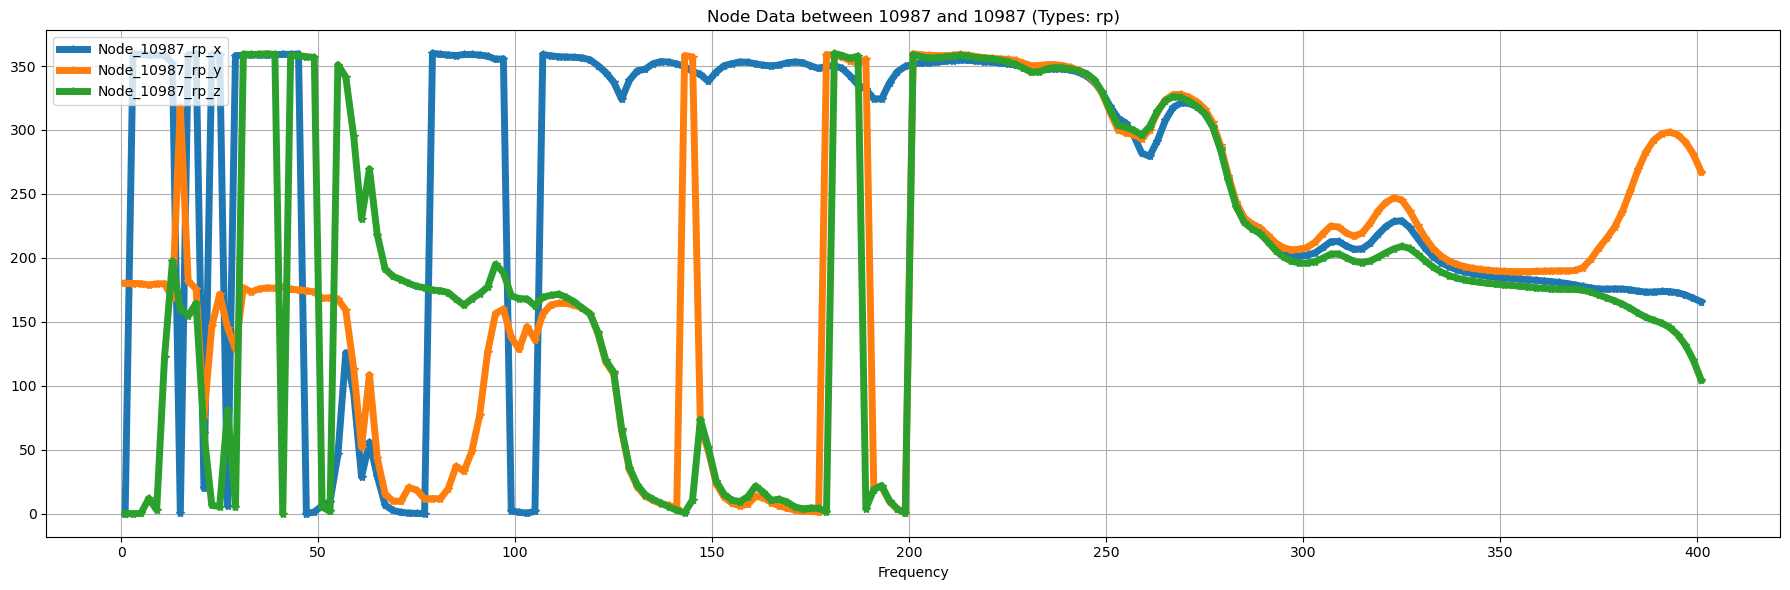

In [98]:
import pandas as pd
import matplotlib.pyplot as plt


# Get user input for node range
start_node = int(input("Please enter the start node (default=11000): ") or 11000)
end_node = int(input("Please enter the end node (default=14000): ") or 12000)

# Get user input for measurement types
measurement_input = input("Enter measurement types to plot (comma separated, e.g., 'tm,rm,rp', default=tm): ") or 'tm'
measurement_types = [m.strip() for m in measurement_input.split(',')]

# Filter columns based on node numbers and measurement types
selected_columns = ['Frequency']  # Always include Frequency column
for col in df.columns:
    if 'Node_' in col:
        node_num = int(col.split('_')[1])  # Extract node number
        if start_node <= node_num <= end_node:
            # Check if column matches any of the requested measurement types
            for mtype in measurement_types:
                if f'_{mtype}_' in col:
                    selected_columns.append(col)
                    break

# Create filtered dataframe
filtered_df = df[selected_columns]

# Plotting
plt.figure(figsize=(18, 6))

# Plot each column against Frequency
for col in filtered_df.columns:
    if col != 'Frequency':
        plt.plot(filtered_df['Frequency'], filtered_df[col], label=col,linewidth = 5,marker = '*' )

plt.xlabel('Frequency')
# plt.ylabel('Values')
plt.title(f'Node Data between {start_node} and {end_node} (Types: {", ".join(measurement_types)})')
plt.legend( loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## Validating Dataset From HG

Index(['Frequency [Hz]', 'PHA | X-Rot', 'PHA | Y-Rot', 'PHA | Z-Rot'], dtype='object')


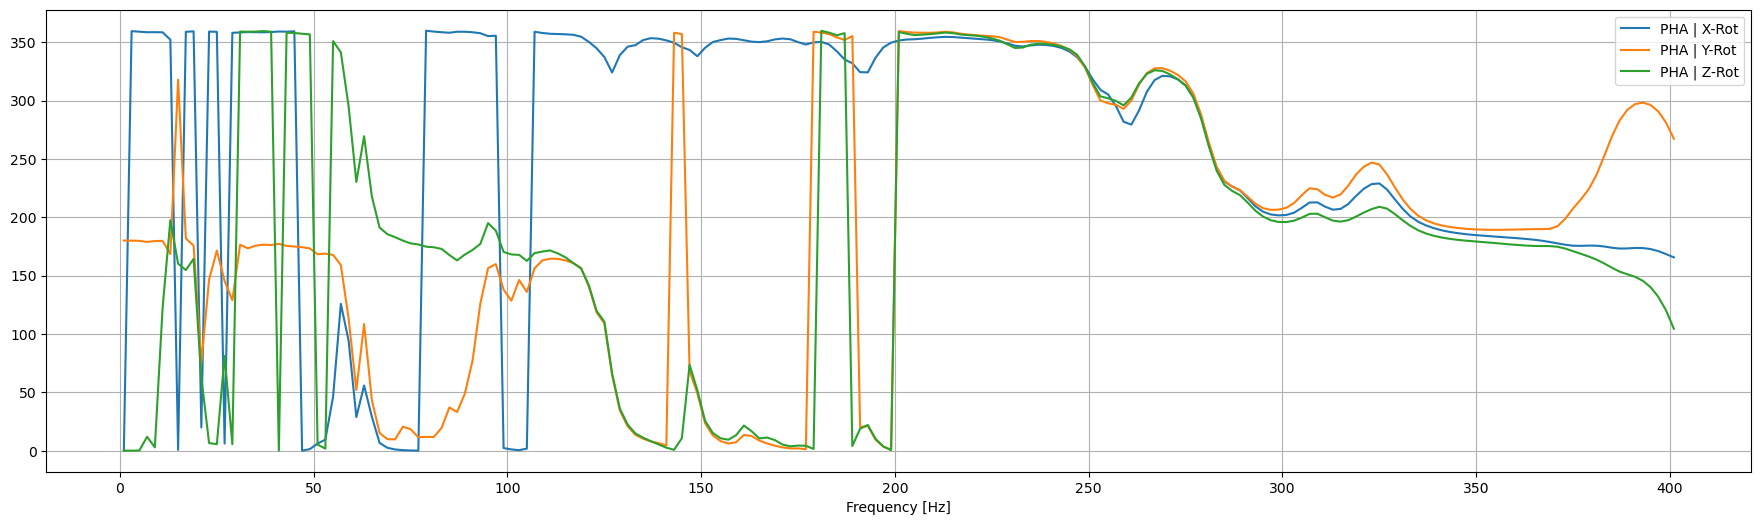

In [100]:
# HG = pd.read_csv(r"E:\Punch File\Vyom_export_10987.csv")
# HG = pd.read_csv(r"E:\Punch File\Vyom_export_10987_rm.csv")
HG = pd.read_csv(r"E:\Punch File\Vyom_export_10987_pr.csv")
# # Remove columns with the same values
# HG = HG.loc[:, (HG.nunique() > 1)]

HG.plot(x = 'Frequency [Hz]',y = ['PHA | X-Rot', 'PHA | Y-Rot', 'PHA | Z-Rot'], figsize =(22,6),grid = True )
# # plt.show()
print(HG.columns)

In [116]:
# plt.figure(figsize=(18, 6))

# # Plot each column separately to assign different colors
# plt.plot(filtered_df['Frequency'], filtered_df['Node_10987_rp_x'], linewidth=5, color='r', label='Node_10987_rp_x')
# plt.plot(filtered_df['Frequency'], filtered_df['Node_10987_rp_y'], linewidth=5, color='b', label='Node_10987_rp_y')
# plt.plot(filtered_df['Frequency'], filtered_df['Node_10987_rp_z'], linewidth=5, color='g', label='Node_10987_rp_z')

# plt.plot(HG['Frequency [Hz]'], HG['PHA | X-Rot'], linewidth=1, color='lime', label='PHA | X-Rot')
# plt.plot(HG['Frequency [Hz]'], HG['PHA | Y-Rot'], linewidth=1, color='orange', label='PHA | Y-Rot')
# plt.plot(HG['Frequency [Hz]'], HG['PHA | Z-Rot'], linewidth=1, color='k', label='PHA | Z-Rot')

# plt.legend()
# plt.show()